# Solution Planning


## Business Problem
   **What is the business problem?**

    Select the most valuable customers to join the "Loyals" loyalty program.

    Answering business questions to the marketing team.

## Output
**What will I deliver? / Where does the business team want to see it?**

List in xls / send by email. It must contain customers who will join Loyals (loyalty program).
Format:
client_id	is_loyal

    │1	│yes
    │2	│no
    
**PDF report answering business questions / send by email and present to the marketing team:**

    Who are the people eligible to participate in the Loyals program?
    How many customers will be part of the group?
    What are the main characteristics of these customers?
    What is the percentage of revenue contribution from Loyals?
    What is the expected revenue for this group for the coming months?
    What are the conditions for a person to be eligible for Loyals?
    What are the conditions for a person to be removed from Loyals?
    What is the guarantee that the Loyals program is better than the rest of the base?
    What actions can the marketing team take to increase revenue?

### Input

Data sources: Dataset "Ecommerce.csv", containing e-commerce sales for the period of one year.

Tools: Python 3.8.12, Jupyter Notebook, Git, Github.

Process
Type of problem: Separation of customers by groups.

Main methods: clustering.

**Business Questions:**

    Who are the people eligible to participate in the Loyals program?
    
    What does it mean to be eligible? / What are higher "value" customers? (depending on business area)
    Invoicing:
    
   - High average ticket
       High LTV (sum of customer revenue)
       
       Low recency (time since last purchase)
       
       High basket size (qty products purchased per purchase)
       
       Low churn probability (would use the output of a model)
       
       High LTV Prediction (would use output from a model)
       
       High propensity to buy (would use the output of a model)
       
              
   - Cost:
        Low return rate
        
   - Shopping experience:
   
        High average of the evaluations

## Solution Benchmarking
Desk Research
Reading articles on customer segmentation on the internet to understand what the market is doing.

Identify from market solutions, with the business team, what we can do as an MVP.

RFM segmentation model.

# Imports

In [142]:
import warnings
import re
import scipy.stats       as st
import sweetviz as sv
import inflection
import pandas            as pd
import seaborn           as sns
import datetime          as dt
from matplotlib  import pyplot as plt
from sklearn import preprocessing as pp
from sklearn import ensemble as en
import umap.umap_   as umap
from sklearn             import decomposition as dd
from sklearn import cluster as c
from sklearn import metrics as m
from scipy.cluster            import hierarchy as hc
from sklearn                  import mixture as mx
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
warnings.filterwarnings('ignore')

## Helper Functions

In [2]:
# Função para formatar notação científica
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Tamanho dos Graficos
sns.set(style = "darkgrid")
sns.set(rc={"figure.figsize":(15, 10)})
#pd.options.display.float_format = "{:,.2f}".format


## Load Data

In [3]:
df_raw = pd.read_csv('data/ecommerce.csv',encoding='unicode_escape')

In [4]:
df_raw = df_raw.drop('Unnamed: 8', axis=1)

# Data Description

In [5]:
df1 = df_raw.copy()

## Rename Columns

In [6]:
#Renomear as colunas do dataset microdados
cols_old = list(df1)


#Função para renomear colunas

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map( snakecase, cols_old) )

#Rename
df1.columns = cols_new

## Data Dimensions

In [7]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## Data Dtypes

In [8]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## Check NA

In [9]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## Drop NA

In [10]:
df1 = df1.dropna()

The most NA values are in the customer_id column. 
In this first step, I decided to exclude the NA values, as it isn't possible to fill in these values without further information.

## Change dtypes

In [11]:
# invoicedate
df1['invoice_date'] = pd.to_datetime( df1['invoice_date'], format='%d-%b-%y')

#customerid
df1['customer_id'] = df1['customer_id'].astype('int64')
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## Descriptive Statistics

In [12]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

### Numerical Attributes

In [13]:
#central tendency - mean, median, 
ct1 = pd.DataFrame(num_attributes.apply(np.mean) ).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - std, 
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew()) ).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis()) ).T

#Merge
n = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
n.columns = ['attributes', 'min', 'max', 'range','mean', 'median', 'std','skew','kurtosis']
n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,-80995.0000,80995.0000,161990.0000,12.0613,5.0000,248.6931,0.1827,94317.5637
1,unit_price,0.0000,38970.0000,38970.0000,3.4605,1.9500,69.3151,452.2190,246924.5430
2,customer_id,12346.0000,18287.0000,5941.0000,15287.6906,15152.0000,1713.5982,0.0298,-1.1800


### Categorical Attributes

In [14]:
# problem: The invoice has numbers and letters

df_letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x ) ) ), :]

#Check if all invoices are letter
print(f'total de invoices com letras: {len(df_letter_invoices)}')

#Check if all invoices are negative
print(f'total de invoices com valores negativos: {len(df_letter_invoices[ df_letter_invoices["quantity"] < 0 ])}')

total de invoices com letras: 8905
total de invoices com valores negativos: 8905


### Stoke_code

In [15]:
at_least_one_string = len(cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x: bool( re.search('[^0-9]+', x))), 'stock_code'].drop_duplicates())

cat_attributes.loc[ cat_attributes['stock_code'].apply( lambda x:  bool( re.search( '^[a-zA-z]+$', x))),'stock_code'].unique()

#Ação
# Remover 'POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY', 'DCGSSGIRL', 'PADS', 'B', 'CRUK'

array(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'], dtype=object)

### Country

In [16]:
len(df1['country'].unique())

37

In [17]:
# country x purchases
df1['country'].value_counts(normalize=True)

United Kingdom         0.8895
Germany                0.0233
France                 0.0209
EIRE                   0.0184
Spain                  0.0062
Netherlands            0.0058
Belgium                0.0051
Switzerland            0.0046
Portugal               0.0036
Australia              0.0031
Norway                 0.0027
Italy                  0.0020
Channel Islands        0.0019
Finland                0.0017
Cyprus                 0.0015
Sweden                 0.0011
Austria                0.0010
Denmark                0.0010
Japan                  0.0009
Poland                 0.0008
USA                    0.0007
Israel                 0.0006
Unspecified            0.0006
Singapore              0.0006
Iceland                0.0004
Canada                 0.0004
Greece                 0.0004
Malta                  0.0003
United Arab Emirates   0.0002
European Community     0.0001
RSA                    0.0001
Lebanon                0.0001
Lithuania              0.0001
Brazil    

# Filtering Variable

In [18]:
df2 = df1.copy()

In [19]:
#=====================Numerical Attributes=================================
#Quantity
df2 = df2.loc[df2['unit_price']>= 0.04]


#=====================Caterical Attributes=================================
df2 = df2[~df2['stock_code'].isin( ['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

#Description
df2 = df2.drop(columns='description', axis=1)

#map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

#Quantity
df_return = df2.loc[df1['quantity']<0, :]
df2_purchase = df2.loc[df1['quantity']>= 0, :]

#Bad Users
df2 = df2[~df2['customer_id'].isin( [16446] )]

# Feature Engeneering

In [20]:
df3 = df2.copy()

In [21]:
#create the referente table with uniques customer_id (and reset index)
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True).copy()

In [22]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


## Gross Revenue

In [23]:
# Gross Revenue ( Faturamento ) quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity'] * df2_purchase.loc[:, 'unit_price']

# Monetary (How much money a customer spends on purchases)
df_monetary = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).sum().reset_index()
df_ref = pd.merge( df_ref, df_monetary, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
dtype: int64

## Recency

In [24]:
# Recency - Day from last purchase
df_recency = df2_purchase.loc[:, ['customer_id', 'invoice_date']].groupby( 'customer_id' ).max().reset_index()
df_recency['recency_days'] = ( df1['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()

df_ref = pd.merge( df_ref, df_recency, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id       0
gross_revenue    27
recency_days     27
dtype: int64

## Quantity of Purchases

In [25]:
# Quantity of purchases (quantity of invoice no)
df_freq = (df2_purchase.loc[:, ['customer_id', 'invoice_no']].drop_duplicates()
                                                             .groupby( 'customer_id' )
                                                             .count()
                                                             .reset_index()
                                                             .rename(columns = {'invoice_no': 'qty_invoice_no'}))
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
dtype: int64

## Quantity of Items Purchased by Customer

In [26]:
# Quantity of items purchased by customer
df_freq = (df2_purchase.loc[:, ['customer_id', 'quantity']].groupby( 'customer_id' ).sum()
                                                           .reset_index()
                                                           .rename( columns={'quantity': 'qty_items'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qty_items         27
dtype: int64

## Quantity of Products Purchased

In [27]:
# Quantity of unique products purchased (Frequency: qntd of products over time)

# Number of products (different stock codes by customer)
df_freq = (df2_purchase.loc[:, ['customer_id', 'stock_code']].groupby( 'customer_id' ).count()
                                                           .reset_index()
                                                           .rename( columns={'stock_code': 'qty_products'} ) )
df_ref = pd.merge( df_ref, df_freq, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qty_items         27
qty_products      27
dtype: int64

## Average Ticket Value

In [28]:
# Average Ticket Value
df_avg_ticket = df2_purchase.loc[:, ['customer_id', 'gross_revenue']].groupby( 'customer_id' ).mean().reset_index().rename( columns={'gross_revenue':'avg_ticket'} )
df_ref = pd.merge( df_ref, df_avg_ticket, on='customer_id', how='left')
df_ref.isna().sum()

customer_id        0
gross_revenue     27
recency_days      27
qty_invoice_no    27
qty_items         27
qty_products      27
avg_ticket        27
dtype: int64

## Average Recency Days

In [29]:
# Average recency days
df_aux = df1[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'], ascending=False )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

#average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qty_invoice_no        27
qty_items             27
qty_products          27
avg_ticket            27
avg_recency_days    1370
dtype: int64

## Frequency

In [30]:
#Frequency Purchase (rate: purchases by day)
df_aux = ( df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                             .groupby( 'customer_id')
                                                             .agg( max_ = ( 'invoice_date', 'max' ), 
                                                                   min_ = ( 'invoice_date', 'min' ),
                                                                   days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                   buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()
# Frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if  x['days_'] != 0 else 0, axis=1 )

# Merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qty_invoice_no        27
qty_items             27
qty_products          27
avg_ticket            27
avg_recency_days    1370
frequency             27
dtype: int64

## Number of Returns

In [31]:
#Number of Returns
df_returns = df_return[['customer_id', 'quantity']].groupby( 'customer_id' ).sum().reset_index().rename( columns={'quantity':'qtde_returns'} )
df_returns['qtde_returns'] = df_returns['qtde_returns'] * -1

df_ref = pd.merge( df_ref, df_returns, how='left', on='customer_id' )
df_ref.loc[df_ref['qtde_returns'].isna(), 'qtde_returns'] = 0 #customers with 0 returned items

df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qty_invoice_no        27
qty_items             27
qty_products          27
avg_ticket            27
avg_recency_days    1370
frequency             27
qtde_returns           0
dtype: int64

## Basket Size

In [32]:
#Basket Size - the number of products sold in a single purchase ( Quantity )
# Invoice No = Purchase = purchase
# Stock Code = Produto Único = Product
# Quantity = Item = Item

df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'quantity']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'quantity', 'sum' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id            0
gross_revenue         27
recency_days          27
qty_invoice_no        27
qty_items             27
qty_products          27
avg_ticket            27
avg_recency_days    1370
frequency             27
qtde_returns           0
avg_basket_size       27
dtype: int64

## Unique Basket Size

In [33]:
#Unique Basket Size - Quantidade de produtos distintos por compra

df_aux = ( df2_purchase.loc[:, ['customer_id', 'invoice_no', 'stock_code']].groupby( 'customer_id' )
                                                                            .agg( n_purchase=( 'invoice_no', 'nunique'),
                                                                                   n_products=( 'stock_code', 'nunique' ) )
                                                                            .reset_index() )

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge( df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id' )
df_ref.isna().sum()

customer_id                  0
gross_revenue               27
recency_days                27
qty_invoice_no              27
qty_items                   27
qty_products                27
avg_ticket                  27
avg_recency_days          1370
frequency                   27
qtde_returns                 0
avg_basket_size             27
avg_unique_basket_size      27
dtype: int64

# EDA

1) do analysis to validate business hypotheses, combat business guesswork

2) study data space in which the data are inserted.

In [34]:
df4 = df_ref.dropna()

In [35]:
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qty_invoice_no            0
qty_items                 0
qty_products              0
avg_ticket                0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## Análise Univariada
Usar o Sweetviz

In [36]:
#generate report with Pandas Profiling Report
#my_report2 = sv.analyze(df4)
#my_report2.show_html() 

- AO analisar o relatório do sweetviz observei que tem um valor muito alto. Vamos dar um zoom nesse id e ver do que se trata

### Quantity Items

In [37]:
df4.loc[df4['qty_items']==196844]

,customer_id,gross_revenue,recency_days,qty_invoice_no,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
908,14646,279138.0200,1.0000,72.0000,196844.0000,2060.0000,135.5039,-7.6739,0.2034,288.0000,2733.9444,9.7083


Esse cliente fez a compra ha 1 dia, comprou 2060 produtos m tem uma frequencia de 20

In [38]:
df3[df3['customer_id']==14646].head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
37952,539491,21981,12,2016-12-18,0.2900,14646,Netherlands
37953,539491,21986,12,2016-12-18,0.2900,14646,Netherlands
37954,539491,22720,2,2016-12-18,4.9500,14646,Netherlands
37955,539491,21931,1,2016-12-18,1.9500,14646,Netherlands
37956,539491,22613,2,2016-12-18,0.8500,14646,Netherlands
37957,539491,20751,1,2016-12-18,2.1000,14646,Netherlands
37958,539491,21246,2,2016-12-18,4.9500,14646,Netherlands
37959,539491,22960,1,2016-12-18,4.2500,14646,Netherlands
37960,539491,22355,2,2016-12-18,0.8500,14646,Netherlands
37961,539491,21123,2,2016-12-18,1.2500,14646,Netherlands


**- What appears is a recurring customer who buys large quantities in small amounts**

### AVG Ticket

The AVG ticket also showed an outlier.
It is noticed that it is the same as the previous customer, therefore, the decision is to exclude this id, as it generates an outlier and distorts the data information.

In [39]:
#df4[df4['avg_ticket']==56157.5]

### Frequency

In [40]:
df4[df4['frequency']==17]

,customer_id,gross_revenue,recency_days,qty_invoice_no,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,-35.5000,17.0000,40.0000,50.9706,0.6176


In [41]:
df3[df3['customer_id']==17850].head(20)

,invoice_no,stock_code,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,6,2016-11-29,2.5500,17850,United Kingdom
1,536365,71053,6,2016-11-29,3.3900,17850,United Kingdom
2,536365,84406B,8,2016-11-29,2.7500,17850,United Kingdom
3,536365,84029G,6,2016-11-29,3.3900,17850,United Kingdom
4,536365,84029E,6,2016-11-29,3.3900,17850,United Kingdom
5,536365,22752,2,2016-11-29,7.6500,17850,United Kingdom
6,536365,21730,6,2016-11-29,4.2500,17850,United Kingdom
7,536366,22633,6,2016-11-29,1.8500,17850,United Kingdom
8,536366,22632,6,2016-11-29,1.8500,17850,United Kingdom
47,536372,22632,6,2016-11-29,1.8500,17850,United Kingdom


The graph shows that the distribution is affected by extreme values. Therefore, most customers spent less than 1.00 during the period under review.

### AVG Basket size

- In the graph, you can see that most purchases were made in the last 100 days
- But there are customers who have not made purchases for 373 days

In [42]:
#df4[df4['avg_basket_size']==40498.5]

## Bivariate Analysis

- analyze a feature in relation to all others

In [43]:
#cols = ['customer_id']
#df4 = df3.copy()

In [44]:
#plt.figure( figsize = (25, 12))
#sns.pairplot(df4);

# Feature Selection

In [61]:
cols_selected = ['customer_id', 'gross_revenue','recency_days', 'qty_products', 'frequency', 'qtde_returns']
df43 = df4[cols_selected].copy()

# Data Preparation

In [62]:
mm = pp.MinMaxScaler()

df43['gross_revenue']         =  mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']          =  mm.fit_transform(df43[['recency_days']])
df43['qty_products']         =  mm.fit_transform(df43[['qty_products']])
df43['frequency']             =  mm.fit_transform(df43[['frequency']])
df43['qtde_returns']          =  mm.fit_transform(df43[['qtde_returns']])

In [63]:
X = df43.copy()
X.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qtde_returns
0,17850,0.0193,0.9973,0.0378,1.0000,0.0044
1,13047,0.0116,0.1501,0.0217,0.0013,0.0039
2,12583,0.0240,0.0054,0.0295,0.0021,0.0055
3,13748,0.0034,0.2547,0.0034,0.0007,0.0000
4,15100,0.0031,0.8928,0.0003,0.0040,0.0024


## Estudo do Espaco

## PCA

PCA is a technique that simplifies a dataset by finding linear combinations of the original features, called principal components. It helps identify patterns and reduce data dimensionality while retaining the most important information.


In [139]:
#pca = dd.PCA( n_components = X.shape[1])
#
#
#principal_components = pca.fit_transform(X)
#
## plot explained variables
#features = range(pca.n_components_)
#
#plt.bar(features, pca.explained_variance_ratio_, color = 'black') #quais componentes principais com a maior variação de dados
#
## pca component
#df_pca = pd.DataFrame( principal_components )

### UMAP

UMAP is a dimensionality reduction algorithm that is based on the concept of neighborhood approximations, where each point is compared to its close neighbors to build a graph. This graph is then optimized to preserve the original structure of the data in a smaller dimension space.


In [140]:
#reducer = umap.UMAP(random_state = 42)
#embedding = reducer.fit_transform(X) #gera o espaço projetado - embedding é a projeção gerada em outro espaço
#
##embedding
#df_pca['embedding_X'] = embedding[:, 0]
#df_pca['embedding_y'] = embedding[:, 1]
#
##plot UMAP - cluster projetado de alta dimencionalidade
#sns.scatterplot(x = 'embedding_X', y = 'embedding_y',
#                data = df_pca);

### Tree-Based Embedding

Tree-Based Embedding is a technique that uses a decision tree to simplify complex data. It helps us to group people or objects based on their characteristics, providing a clearer and easier to understand representation.
This technique is especially useful when we have many characteristics and want to understand how they are related to group people or objects more clearly.

In [67]:
# training dataset

X = df43.drop(columns = ['customer_id', 'gross_revenue'], axis = 1)
y = df43['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators = 100, random_state = 42)

# model training
rf_model.fit(X,y)

RandomForestRegressor(random_state=42)

In [68]:
df_leaf = pd.DataFrame(rf_model.apply( X ))

df_leaf.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,3764,3360,3716,3462,3593,3661,3641,3595,3598,3431,...,3469,3670,3644,3689,3594,3676,3565,3642,3679,3611
1,3306,3004,3429,3361,3234,3282,3206,3444,3464,3332,...,3333,3014,3294,2997,3263,3226,3333,3063,3107,3436
2,3418,3331,3492,3441,3259,3397,3298,3608,3547,3321,...,3429,3193,3323,3604,3258,3345,3414,3617,3587,3691
3,1246,1100,1542,514,346,1239,914,961,369,376,...,1140,570,856,337,1029,846,890,1578,1276,485
4,512,367,38,794,736,612,481,480,720,752,...,563,882,541,959,512,469,366,139,755,615


- y = number of estimators, number of trees (decision tree each column)
- x = customers
- xy (points within the matrix) = position of the leaf that the customer fell on each tree

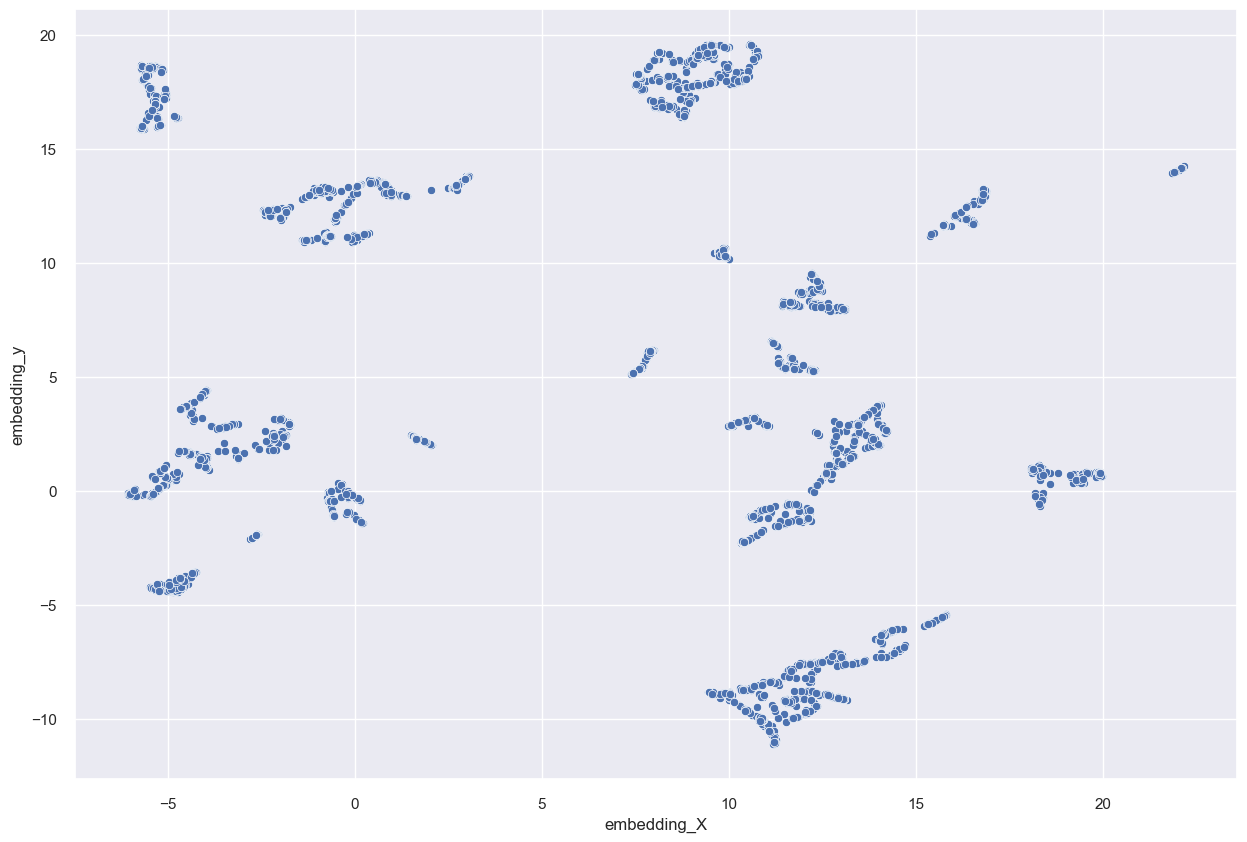

In [69]:
# using UMAP to reduce the space study from 100 to 2
reducer = umap.UMAP(random_state = 42)
embedding = reducer.fit_transform(df_leaf) #gera o espaço projetado - embedding é a projeção gerada em outro espaço

#embedding
df_tree = pd.DataFrame()
df_tree['embedding_X'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

#plot UMAP - cluster projetado de alta dimencionalidade
sns.scatterplot(x = 'embedding_X', y = 'embedding_y',
                data = df_tree);

# Hyper Parameter Fine-Tuning

In [70]:
#drop customer_id
X = df_tree.copy()
X.head()

,embedding_X,embedding_y
0,11.4913,-8.1539
1,18.2693,-0.1774
2,12.1070,-7.5721
3,-5.5520,17.8015
4,-3.6493,1.7451


For a good clustering, we need clusters to have two properties:

- Compactness: smallest possible distance between the points of the same cluster.
- Separation: greatest possible distance between the points of different clusters.
Let's use k-means with 2 metrics:

1 - Within-Cluster Sum of Square (WSS) - calculates Compactness
 
2 - Silhouette Score (SS) - calculates Compactness and Separation

In [71]:
#clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]
clusters = np.arange(2,28,1)
clusters

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27])

## K-Means

In [72]:
kmeans_list = []
for k in clusters:
    #model definition
    kmeans_model = c.KMeans( n_clusters=k )

    #model training
    kmeans_model.fit(X)

    #Model predict
    kmeans_labels = kmeans_model.predict(X)
    #labels: array([1, 5, 5, ..., 5, 3, 5], dtype=int32)
        
   #model perfomance (SS)
    kmeans_sil = m.silhouette_score(X, kmeans_labels, metric='euclidean')
    kmeans_list.append(kmeans_sil)

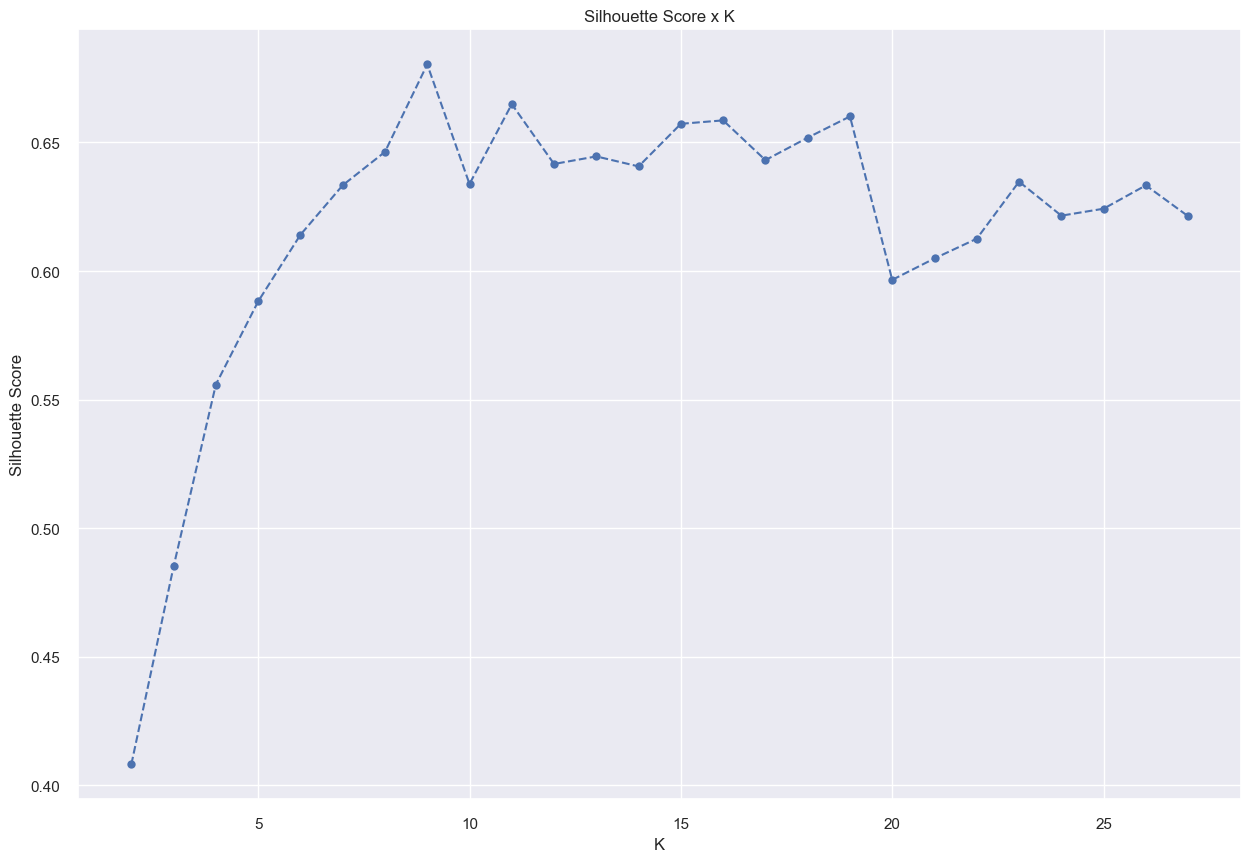

In [73]:
#Silhouette Score
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## Gaussian Mixture Model

In [74]:
gmm_list = []
for k in clusters:
    #model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    gmm_labels = gmm_model.predict(X)

    #model perfomance (SS)
    gmm_sil = m.silhouette_score(X, gmm_labels, metric='euclidean')
    gmm_list.append(gmm_sil)

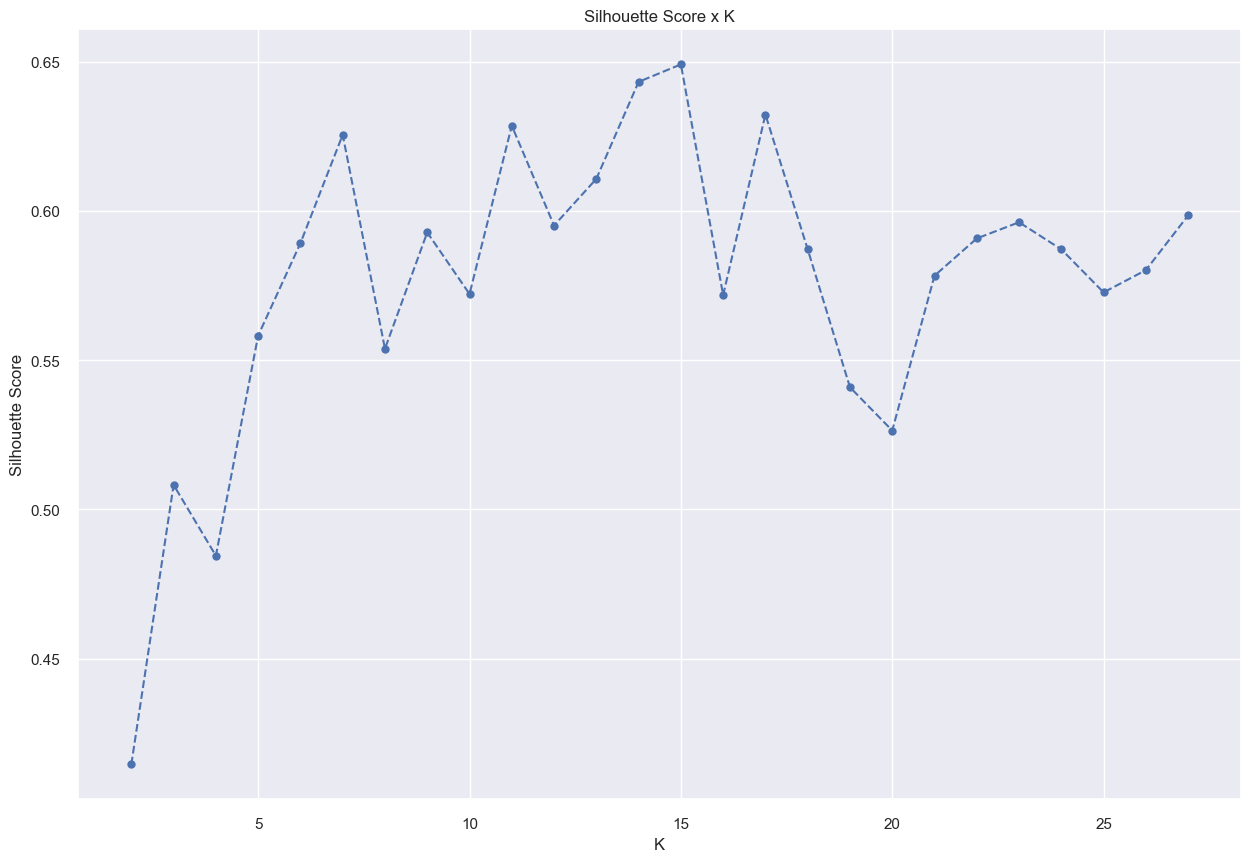

In [75]:
#Silhouette Score (with feature selection done before creating embedding space)
plt.plot(clusters, gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

## Hierarchical Clustering

In [76]:
#using scipy instead of sklearn, so model definition and training are done toghether
k=2
hc_list = []
for k in clusters:
    #model definition and training
    hc_model = hc.linkage(X, 'ward')

    #model predict
    hc_labels = hc.fcluster(hc_model, k, criterion='maxclust')#to cut dendrogram

    #model perfomance (SS)
    hc_sil = m.silhouette_score(X, hc_labels, metric='euclidean')
    hc_list.append(hc_sil) 

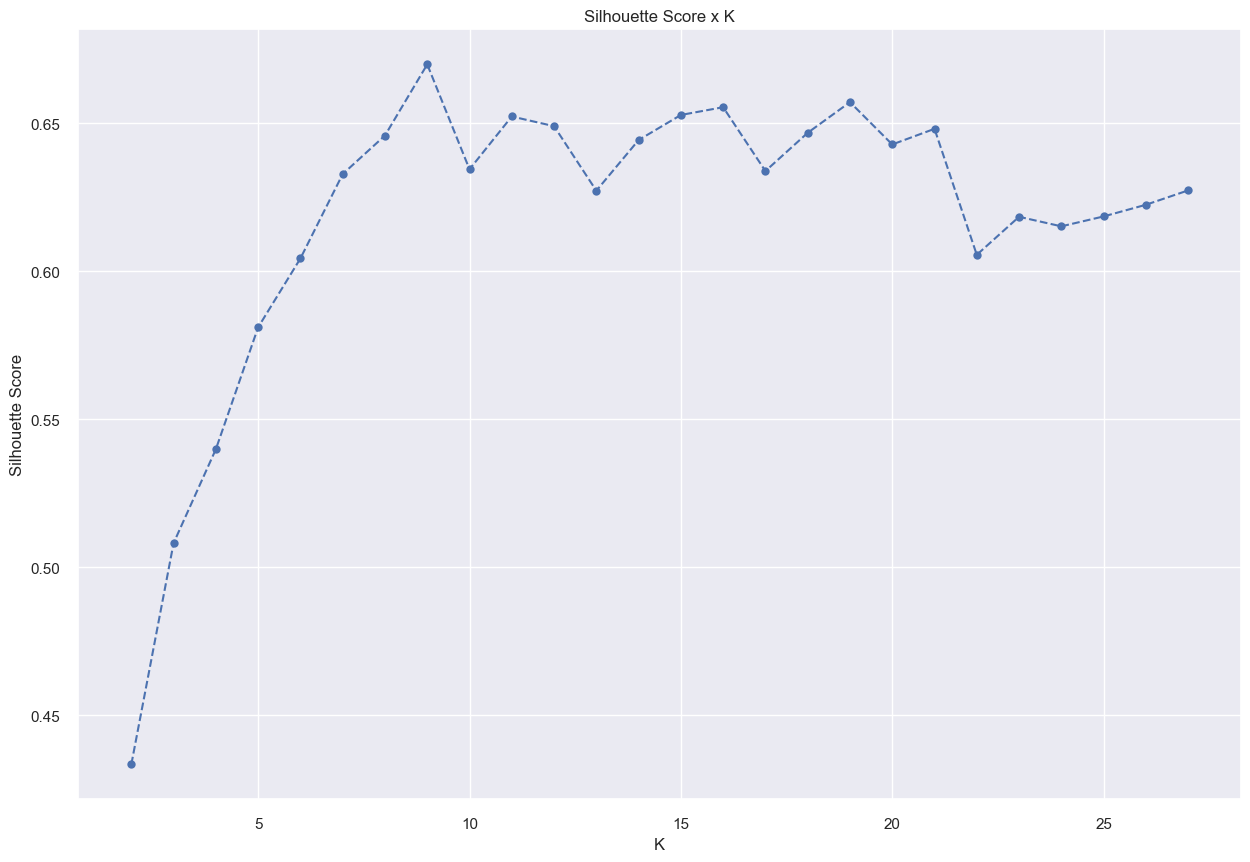

In [77]:
#Silhouette Score (with feature selection done before creating embedding space)
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K');

[]

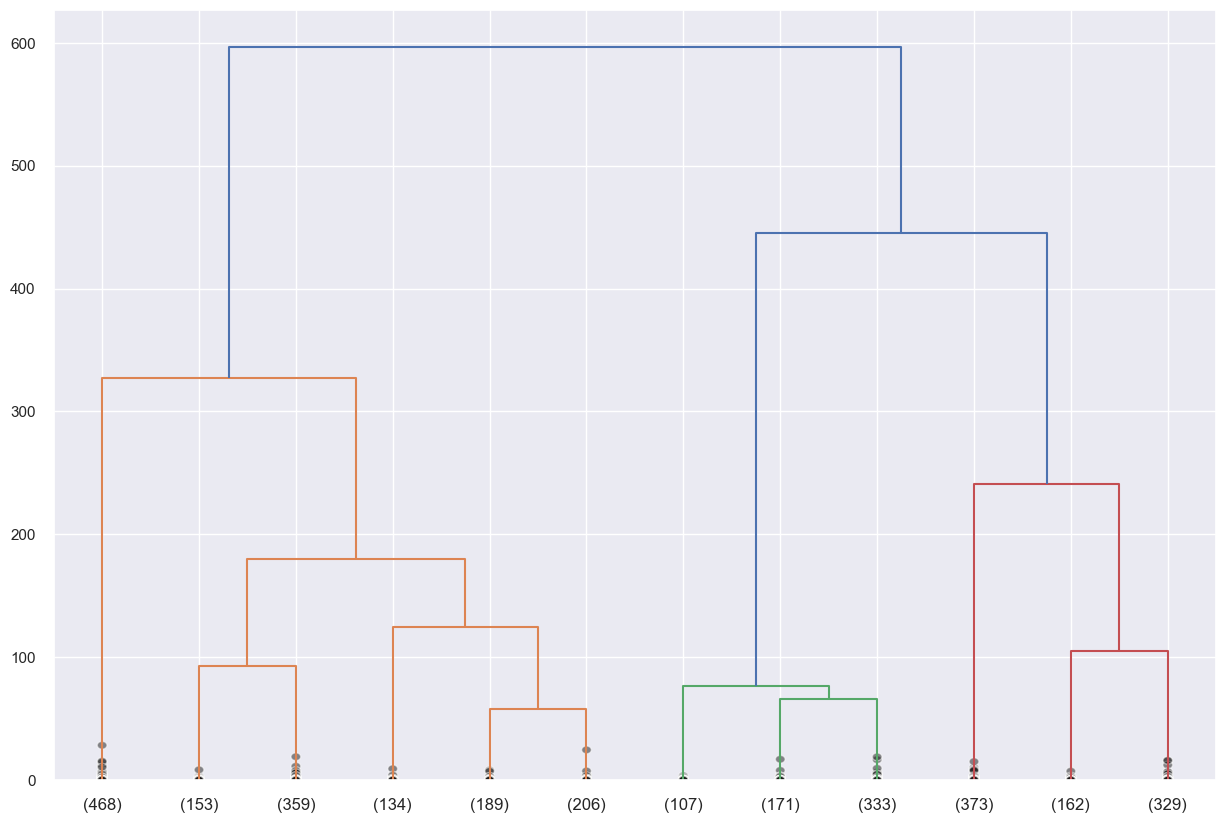

In [78]:
#truncated dendrogram
hc.dendrogram(
    hc_model,
    #leaf_rotation=90,
    #leaf_font_size=8,
    truncate_mode='lastp',#take out for complete (heavy)
    p=12, #truncate after 12 
    show_contracted=True
)
plt.plot()

## Results

In [79]:

df_results = pd.DataFrame({'K-Means':kmeans_list, 'GMM':gmm_list, 'HC':hc_list }).T
df_results.columns = clusters
#highlight best cluster per algorithm according to SS 
df_results.style.highlight_max(color='green', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
K-Means,0.408179,0.485130,0.555873,0.588183,0.614100,0.633351,0.646340,0.680361,0.633851,0.664904,0.641638,0.644584,0.640690,0.657255,0.658594,0.643137,0.651858,0.660124,0.596579,0.604914,0.612587,0.634767,0.621539,0.624247,0.633329,0.621318
GMM,0.414556,0.508177,0.484473,0.558208,0.589161,0.625490,0.553814,0.592788,0.572157,0.628540,0.595105,0.610733,0.643231,0.649086,0.571801,0.632268,0.587141,0.540904,0.526417,0.578287,0.590767,0.596193,0.587108,0.572700,0.580161,0.598483
HC,0.433406,0.508177,0.539897,0.581082,0.604340,0.632846,0.645871,0.669907,0.634463,0.652308,0.649034,0.627232,0.644344,0.652819,0.655437,0.633867,0.646788,0.657146,0.642854,0.648134,0.605566,0.618419,0.615192,0.618538,0.622476,0.627335


# Machine Learning Model

## K-Means

In [80]:
k = 10
#model definition
kmeans = c.KMeans( init='random', #init centroids ramdomly
                  n_clusters=k, #3
                  n_init=20, #Num of times k-means will be run with different centroid seeds.
                  max_iter=300, #up to 300 times
                 random_state=42) #seed, to generate the same random init
#model training
kmeans.fit(X)
#get cluster of each row
kmeans_labels = kmeans.labels_

## Gaussian Mixture Model

In [82]:
k=10
#Model definition
gmm_model = mx.GaussianMixture(n_components=k, n_init=300, random_state=42)


#Model training
gmm_model.fit( X )

#Clustering
labels = gmm_model.predict(X)

## Final Model

Let's go with the k-Means

In [115]:
k = 8
#model definition
kmeans = c.KMeans( init='random', #init centroids ramdomly
                  n_clusters=k, #3
                  n_init=20, #Num of times k-means will be run with different centroid seeds.
                  max_iter=300, #up to 300 times
                 random_state=42) #seed, to generate the same random init
#model training
kmeans.fit(X)
#get cluster of each row
kmeans_labels = kmeans.labels_

## Cluster Validation

In [116]:
# WSS (Within-cluster Sum of Square )
print('WSS score: {}'.format(kmeans.inertia_))

# SS (Silhouette Score)
print('SS score: {}'.format(m.silhouette_score(X, kmeans_labels, metric = 'euclidean')))

WSS score: 21184.66796875
SS score: 0.6467858552932739


# Cluster Analysis Variable

In [117]:
df9 = df4.copy()
df9['cluster'] = labels
df9.head()

,customer_id,gross_revenue,recency_days,qty_invoice_no,qty_items,qty_products,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size,cluster
0,17850,5391.2100,372.0000,34.0000,1733.0000,297.0000,18.1522,-35.5000,17.0000,40.0000,50.9706,0.6176,4
1,13047,3232.5900,56.0000,9.0000,1390.0000,171.0000,18.9040,-26.3077,0.0283,35.0000,154.4444,11.6667,1
2,12583,6705.3800,2.0000,15.0000,5028.0000,232.0000,28.9025,-21.8235,0.0403,50.0000,335.2000,7.6000,4
3,13748,948.2500,95.0000,5.0000,439.0000,28.0000,33.8661,-92.6667,0.0179,0.0000,87.8000,4.8000,0
4,15100,876.0000,333.0000,3.0000,80.0000,3.0000,292.0000,-8.6000,0.0732,22.0000,26.6667,0.3333,2


## Visualization Inspection

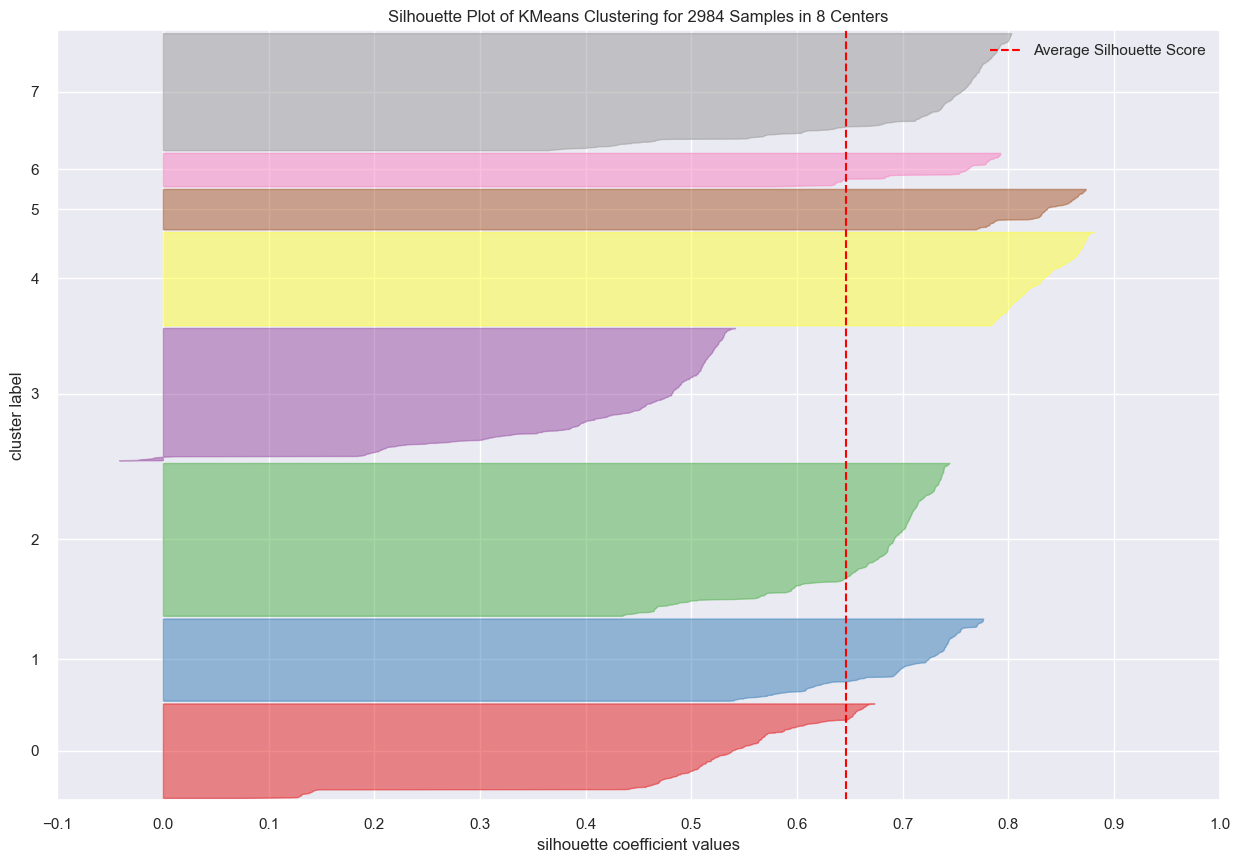

In [118]:
visualizer = SilhouetteVisualizer(kmeans, colores = 'yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## Cluster Profile

In [119]:
df92 = df4[cols_selected]
df92['cluster'] =labels
df92.head()

,customer_id,gross_revenue,recency_days,qty_products,frequency,qtde_returns,cluster
0,17850,5391.2100,372.0000,297.0000,17.0000,40.0000,4
1,13047,3232.5900,56.0000,171.0000,0.0283,35.0000,1
2,12583,6705.3800,2.0000,232.0000,0.0403,50.0000,4
3,13748,948.2500,95.0000,28.0000,0.0179,0.0000,0
4,15100,876.0000,333.0000,3.0000,0.0732,22.0000,2


In [120]:
# Explaining clusters profile based on this averages
# Number of customer
df_cluster = df92[['customer_id', 'cluster']].groupby( 'cluster' ).count().reset_index()
df_cluster['perc_customer'] = 100*( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
df_avg_gross_revenue = df92[['gross_revenue', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_gross_revenue, how='inner', on='cluster' )

# Avg recency days
df_avg_recency_days = df92[['recency_days', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_avg_recency_days, how='inner', on='cluster' )

# Avg qty products
df_qty_products = df92[['qty_products', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qty_products, how='inner', on='cluster' )

# Frequency
df_frequency = df92[['frequency', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_frequency, how='inner', on='cluster' )

# Avg qty returns
df_qty_returns = df92[['qtde_returns', 'cluster']].groupby( 'cluster' ).mean().reset_index()
df_cluster = pd.merge( df_cluster, df_qty_returns, how='inner', on='cluster' )

# cluster profiles
df_cluster.sort_values('gross_revenue', ascending=False)

,cluster,customer_id,perc_customer,gross_revenue,recency_days,qty_products,frequency,qtde_returns
4,4,468,15.6836,8836.1364,21.4380,424.1346,0.0946,149.2714
1,1,153,5.1273,3101.3605,36.4248,172.8954,0.0582,22.5948
5,5,372,12.4665,2691.0882,56.4516,89.3441,0.0644,19.9489
7,7,516,17.2922,2223.1820,45.4845,118.0775,0.0383,19.6725
3,3,373,12.5000,1217.0592,60.8284,54.3887,0.0515,7.1635
6,6,329,11.0255,975.5898,76.0213,37.1763,0.0854,10.7264
0,0,162,5.4290,819.3064,85.7284,27.9444,0.1240,4.0000
2,2,611,20.4759,550.4167,117.0786,14.0949,0.3103,9.5123


In [121]:
loyals_cluster = 4

In [122]:
#generate the repport dinamically:
for i in range(len(df_cluster['customer_id'])):
    
    print(f""" Cluster {df_cluster['cluster'][i]}:
    -Number of customers: {df_cluster['customer_id'][i]} ({round(df_cluster['perc_customer'][i])}%)
    -Average revenue: ${round(df_cluster['gross_revenue'][i])}
    -Average recency: by each {round(df_cluster['recency_days'][i])} days ({round(df_cluster['recency_days'][i]/7)} week(s))
    -Average quantity products purchased: {round(df_cluster['qty_products'][i])} 
    \n """)

 Cluster 0:
    -Number of customers: 162 (5%)
    -Average revenue: $819
    -Average recency: by each 86 days (12 week(s))
    -Average quantity products purchased: 28 
    
 
 Cluster 1:
    -Number of customers: 153 (5%)
    -Average revenue: $3101
    -Average recency: by each 36 days (5 week(s))
    -Average quantity products purchased: 173 
    
 
 Cluster 2:
    -Number of customers: 611 (20%)
    -Average revenue: $550
    -Average recency: by each 117 days (17 week(s))
    -Average quantity products purchased: 14 
    
 
 Cluster 3:
    -Number of customers: 373 (12%)
    -Average revenue: $1217
    -Average recency: by each 61 days (9 week(s))
    -Average quantity products purchased: 54 
    
 
 Cluster 4:
    -Number of customers: 468 (16%)
    -Average revenue: $8836
    -Average recency: by each 21 days (3 week(s))
    -Average quantity products purchased: 424 
    
 
 Cluster 5:
    -Number of customers: 372 (12%)
    -Average revenue: $2691
    -Average recency: by eac

# Business questions

In [123]:
df10 = df92.copy()

In [124]:
df10.sample(10)

,customer_id,gross_revenue,recency_days,qty_products,frequency,qtde_returns,cluster
2189,18263,1213.1600,25.0000,61.0000,0.0132,1.0000,3
2294,15655,560.6700,243.0000,34.0000,1.0000,5.0000,6
1455,13911,2580.9100,57.0000,148.0000,0.0357,0.0000,7
3547,16240,3718.8000,24.0000,135.0000,0.0370,7.0000,7
958,14732,2702.4900,8.0000,147.0000,0.0241,3.0000,7
3095,18101,223.6500,11.0000,41.0000,0.0150,0.0000,6
323,17677,16363.2300,1.0000,304.0000,0.0815,50.0000,4
738,16810,309.5400,192.0000,15.0000,1.0000,2.0000,2
441,16775,1695.6600,10.0000,158.0000,0.0307,0.0000,1
1532,12507,1052.8100,134.0000,19.0000,0.0182,11.0000,2


### Who are the people eligible to participate in the Loyals program?

In [125]:
df10.loc[ df10['cluster'] == loyals_cluster , 'customer_id']

0       17850
2       12583
6       14688
8       15311
12      16029
        ...  
3942    15993
3976    17590
3984    15444
4106    15531
4308    13521
Name: customer_id, Length: 468, dtype: int64

### How many customers will be part of the group?

In [126]:
df10.loc[ df10['cluster'] == loyals_cluster , 'customer_id'].size

468

### What are the main characteristics of these customers?

In [127]:
print(f'Check session Cluster Profile -> Cluster {loyals_cluster}')

Check session Cluster Profile -> Cluster 4


In [128]:
#Info about confidence intervals for Average Revenue
df_loyals = df10.loc[ df10['cluster'] == loyals_cluster , 'gross_revenue']
st.t.interval(alpha = 0.95, #trust level
              df = len(df_loyals-1), #degrees of freedom (df -1)
              loc = np.mean(df_loyals),#mean
              scale = st.sem(df_loyals) ) #std

(6926.952000975534, 10745.320776802242)

In [129]:
np.mean(df_loyals)

8836.136388888888

We can say that in 95 out of 100 customers, the result will be within the range above.

The other 5% clients have a good chance of not being part of the cluster in the future, because they are more distant of the mean.

### What is the percentage of revenue contribution from Loyals?


In [130]:
#total gross revenue = 100%
df_perc_rev_all = df10['gross_revenue'].sum()
#loyal's gross revenue = %?
df_perc_rev_loyals = df10.loc[ df10['cluster'] == loyals_cluster , 'gross_revenue'].sum() 

In [131]:
#calculate percentage:
round((df_perc_rev_loyals / df_perc_rev_all)*100)

52

### What is the expected revenue for this group for the coming months?


Won't be answared right now, cause we would need more data to work with time series.

### What are the conditions for a person to be eligible for Loyals?


The model will tell us. Let's run the model monthly, for example, and each time, we create a Data and Cluster column, and the person will continue in Loyals, or fall into another cluster.

### What are the conditions for a person to be removed from Loyals?


The model will tell us too, works like explained on previous question.

### What is the guarantee that the Loyals program is better than the rest of the base?


An A/B test or a Hypothesis test can be run on next cycles to answer this.

### What actions can the marketing team take to increase revenue?

- Discount
- Purchase preference
- Cheaper shipping
- Visit the company
- Offer personal stylist
- Recommend cross selling
- Offer exclusive content

# Business Results

In [132]:
#median revenue of loyals cluster
median_loyals = df10.loc[df10['cluster'] == loyals_cluster, 'gross_revenue'].median() 
#median revenue of all clusters
median_all = df10['gross_revenue'].median() 
median_loyals

4086.705

In [133]:
median_loyals

4086.705

In [134]:
median_all

1079.635

In [138]:
#calculation
((median_loyals - median_all) / median_all)*100

278.5265390618125

In [136]:
#calculations

#number of loyals today
tot_loyals_today = df10.loc[df10['cluster'] == loyals_cluster, 'customer_id'].count()

#expected loyals on next year (10% more)
tot_loyals_nextyear = round(df10.loc[df10['cluster'] == loyals_cluster, 'customer_id'].count()*1.1)

#number of new loyals
exp_new_loyals = tot_loyals_nextyear - tot_loyals_today

#gross revenue expectation
 # median revenue of loyals cluster (from H3)
add_revenue_exp = exp_new_loyals * median_loyals

In [141]:
print(f"""Regarding financial results, we start from the fact that the median revenue of the Loyals cluster is (2,78) greater than the median revenue of all clusters, as already explained.

With the premise that the Stand Out Brands marketing team, through the project, will increase the number of Loyals by 10% in the next year, we will have in 10% of the base, a median increase in revenue of 2,78x.

The number of Loyals customers in the last year (373 days) was: {tot_loyals_today}.
The number of Loyals customers expected for the next year will be: {tot_loyals_nextyear}.
We will therefore have {exp_new_loyals} new customers.

Assuming the same median revenue per Loyal, the expected revenue increment is ${round(add_revenue_exp)} """)

Regarding financial results, we start from the fact that the median revenue of the Loyals cluster is (2,78) greater than the median revenue of all clusters, as already explained.

With the premise that the Stand Out Brands marketing team, through the project, will increase the number of Loyals by 10% in the next year, we will have in 10% of the base, a median increase in revenue of 2,78x.

The number of Loyals customers in the last year (373 days) was: 468.
The number of Loyals customers expected for the next year will be: 515.
We will therefore have 47 new customers.

Assuming the same median revenue per Loyal, the expected revenue increment is $192075 
